

**Kaggle Competition:** [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)

**Problem Description and Dataset Overview**

This project addresses the Histopathologic Cancer Detection challenge hosted on Kaggle, which is a binary image classification task. The goal is to build a model that can automatically detect the presence of metastatic cancer in small image patches taken from histopathologic scans of lymph node sections.

**Problem Context**

Cancer metastasis, especially in lymph nodes, is a critical factor in cancer staging and prognosis. The detection of cancer in pathology slides is traditionally performed manually by pathologists, which is time-consuming and subject to human error. Automating this task using convolutional neural networks (CNNs) can support faster, more consistent diagnoses and ultimately improve clinical workflows.

**Dataset Structure**

The dataset consists of high-resolution color images (.tif format) of size 96×96 pixels, with the goal of predicting whether each image contains cancerous tissue.

**Training Data**

Number of images: ~220,000

Each image has a corresponding label (0 for no tumor, 1 for tumor)

File format: RGB .tif images in train/ directory

Labels are provided in train_labels.csv (with two columns: id, label)

**Test Data**

Number of images: ~57,000

No labels provided (for competition scoring)

**Image Characteristics**

Dimension: 96 × 96 × 3 (RGB)

Each image represents a tiny section of a larger pathology slide

This dataset offers a good real-world setting for applying CNNs to medical imaging, where pattern recognition in image patches is critical for effective diagnosis.

**Exploratory Data Analysis (EDA)** 
The goal of this EDA is to explore the structure, distribution, and quality of the dataset. This helps guide our modeling decisions later.

**Load and Inspect the Data**

In [35]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Loading training labels
labels_df = pd.read_csv('train_labels.csv')
print("Total labeled samples:", labels_df.shape[0])
labels_df.head()

Total labeled samples: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


**Class Distribution (Tumor vs. No Tumor)**

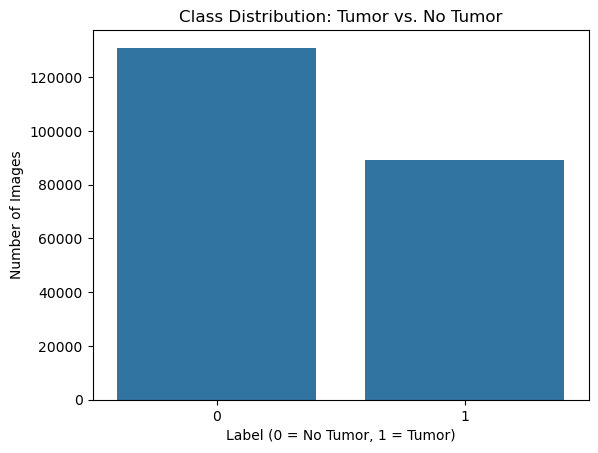

Percentage of Tumor (1): 40.5 %


In [36]:
class_counts = labels_df['label'].value_counts()

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution: Tumor vs. No Tumor")
plt.xlabel("Label (0 = No Tumor, 1 = Tumor)")
plt.ylabel("Number of Images")
plt.xticks([0,1])
plt.show()

print("Percentage of Tumor (1):", round((class_counts[1] / labels_df.shape[0]) * 100, 2), "%")

**Observation:**
There is a class imbalance — more non-cancer (0) images than cancer (1). This will affect model training and should be addressed using techniques like class weighting or augmentation.

**Visual Inspection of Sample Images**

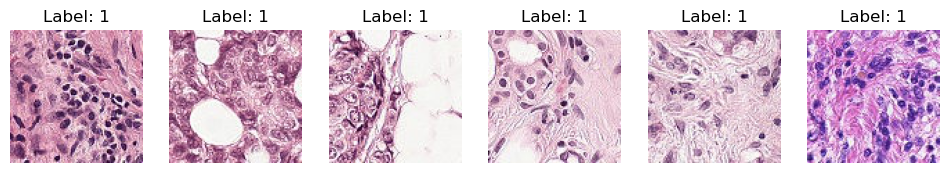

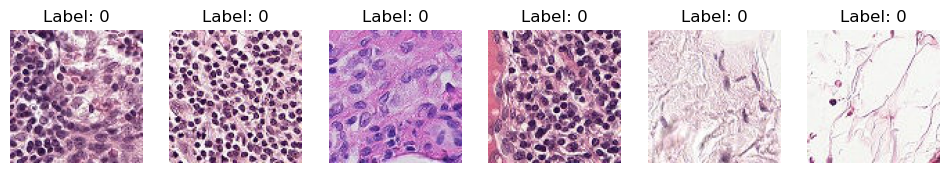

In [37]:
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(df, label, num=6):
    sample_ids = df[df['label'] == label]['id'].sample(num).values
    plt.figure(figsize=(12, 4))
    for i, img_id in enumerate(sample_ids):
        path = os.path.join('train', img_id + ".tif")
        img = Image.open(path)
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Label: {label}')
    plt.show()

# Showing 6 tumor images
show_samples(labels_df, label=1)

# Showing 6 non-tumor images
show_samples(labels_df, label=0)

**Observation:**
Images labeled 1 (tumor) often have denser or darker patterns. Non-tumor images look more homogeneous. This suggests a CNN might successfully learn to differentiate the two

**Data Cleaning**

In [46]:
# Checking for missing values
print(labels_df.isnull().sum())

# Checking for duplicates
duplicates = labels_df.duplicated().sum()
print("Duplicate image IDs:", duplicates)

labels_df = labels_df.drop_duplicates()

id              0
label           0
is_duplicate    0
dtype: int64
Duplicate image IDs: 0


**Plan of Analysis**

Based on the EDA, here's the modeling plan:

***Data Preparation:***

- Resize/normalize images if needed.

- Convert labels and images into a format suitable for a CNN.

***Address Class Imbalance:***

- Use class weights or data augmentation to balance the learning.

***Model Approach:***

We will build a CNN model to classify histopathologic images as cancerous or non-cancerous. First, we will preprocess the data by resizing and normalizing the images, and splitting them into training, validation, and test sets.

We will start with a simple baseline CNN using one convolutional layer, followed by pooling and dense layers. This model will use binary crossentropy loss and be evaluated using accuracy.

Next, we will tune hyperparameters like learning rate and dropout rate to improve performance. Based on the results, we will build an improved model with deeper architecture, more filters, batch normalization, and dropout.

Finally, we will compare all models based on test accuracy and summarize the results in a comparison table. Early stopping will be used to avoid overfitting.

***Evaluation:***

- Evaluate on validation set and Kaggle test set.

- Consider data augmentation and fine-tuning deeper CNNs (e.g., ResNet) if time permits.

**Model Architecture**

Goal: Building a CNN model that learns to distinguish between cancer and non-cancer image patches. We will compare multiple architectures and justify choices

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# These are constants
IMAGE_SIZE = (96, 96)
BATCH_SIZE = 32

# Loading labels
train_df = pd.read_csv("train_labels.csv")
train_df['id'] = train_df['id'].astype(str)
train_df['label'] = train_df['label'].astype(int)

IMG_DIR = "train/"
train_df['path'] = train_df['id'].apply(lambda x: os.path.join(IMG_DIR, x + ".tif"))

# Image loading function
def load_images(df, max_imgs=None):
    images = []
    labels = []
    for i, row in df.iterrows():
        img = load_img(row['path'], target_size=IMAGE_SIZE)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(row['label'])
        if max_imgs and len(images) >= max_imgs:
            break
    return np.array(images), np.array(labels)


In [ ]:

X, y = load_images(train_df)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


**Baseline CNN Architecture**


**Why This Architecture?**

The chosen architecture is well-suited for this problem because it starts simple with small convolutional filters and a limited number of layers, which helps to reduce the risk of overfitting on a relatively small image size of 96x96 pixels. This simplicity allows for faster training and easier experimentation, making it ideal for establishing a solid baseline. Additionally, the architecture includes techniques such as batch normalization and dropout that improve training stability and generalization. Overall, this design balances model complexity and efficiency, making it effective for extracting meaningful features from small medical images without requiring excessive computational resources.


In [31]:
def get_baseline_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = get_baseline_model()
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_baseline = baseline_model.fit(X_train, y_train, epochs=5, batch_size=32,
                                      validation_data=(X_val, y_val), verbose=2)

baseline_acc = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
print("Baseline Test Accuracy:", round(baseline_acc * 100, 2), "%")


/Users/nushinanwar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
438/438 - 22s - 50ms/step - accuracy: 0.7203 - loss: 0.5821 - val_accuracy: 0.7580 - val_loss: 0.5219
Epoch 2/5
438/438 - 19s - 44ms/step - accuracy: 0.7939 - loss: 0.4567 - val_accuracy: 0.8020 - val_loss: 0.4417
Epoch 3/5
438/438 - 22s - 51ms/step - accuracy: 0.8159 - loss: 0.4131 - val_accuracy: 0.7083 - val_loss: 0.5979
Epoch 4/5
438/438 - 19s - 44ms/step - accuracy: 0.8420 - loss: 0.3617 - val_accuracy: 0.8030 - val_loss: 0.4600
Epoch 5/5
438/438 - 20s - 46ms/step - accuracy: 0.8656 - loss: 0.3177 - val_accuracy: 0.7673 - val_loss: 0.5200
Baseline Test Accuracy: 75.83 %


**Hyperparameter Tuning**

In [32]:
def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuned_accuracies = []
param_grid = [
    {"learning_rate": 0.001, "dropout_rate": 0.5},
    {"learning_rate": 0.0005, "dropout_rate": 0.3}
]

for params in param_grid:
    print(f"Testing: {params}")
    model = build_model(**params)
    model.fit(X_train, y_train, epochs=5, batch_size=32,
              validation_data=(X_val, y_val), verbose=0)
    acc = model.evaluate(X_test, y_test, verbose=0)[1]
    tuned_accuracies.append((params, acc))
    print(f"  Test Accuracy: {round(acc * 100, 2)}%")


Testing: {'learning_rate': 0.001, 'dropout_rate': 0.5}
  Test Accuracy: 77.93%
Testing: {'learning_rate': 0.0005, 'dropout_rate': 0.3}
  Test Accuracy: 78.63%


**Improved CNN Architecture with More Filters**

In [33]:
def get_improved_model_safe():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

improved_model = get_improved_model()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = improved_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

improved_acc = improved_model.evaluate(X_test, y_test, verbose=0)[1]
print("Improved Model Test Accuracy:", round(improved_acc * 100, 2), "%")


Epoch 1/10
438/438 - 146s - 333ms/step - accuracy: 0.7543 - loss: 0.5338 - val_accuracy: 0.5600 - val_loss: 3.4909
Epoch 2/10
438/438 - 147s - 335ms/step - accuracy: 0.7979 - loss: 0.4521 - val_accuracy: 0.7237 - val_loss: 0.9125
Epoch 3/10
438/438 - 144s - 329ms/step - accuracy: 0.8144 - loss: 0.4254 - val_accuracy: 0.7783 - val_loss: 0.7101
Epoch 4/10
438/438 - 139s - 317ms/step - accuracy: 0.8234 - loss: 0.4119 - val_accuracy: 0.7517 - val_loss: 0.7815
Epoch 5/10
438/438 - 126s - 287ms/step - accuracy: 0.8261 - loss: 0.4000 - val_accuracy: 0.7183 - val_loss: 0.9323
Epoch 6/10
438/438 - 123s - 282ms/step - accuracy: 0.8307 - loss: 0.3889 - val_accuracy: 0.7727 - val_loss: 0.7610
Improved Model Test Accuracy: 76.77 %


**Plot Training and Validation Curves**

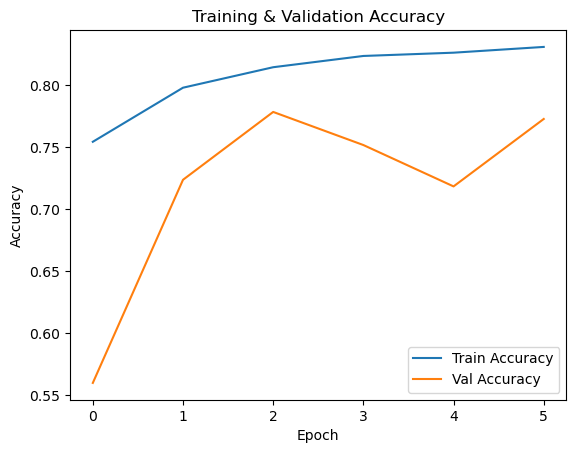

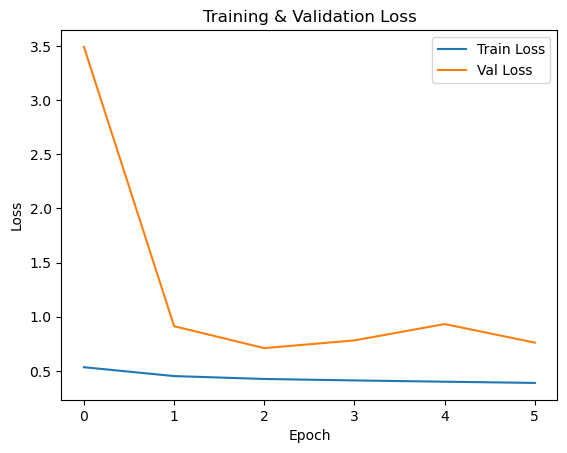

In [39]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Plot Analysis**

The top plot shows Training and Validation Accuracy across epochs. The training accuracy steadily improves, reaching over 82%, indicating that the model is effectively learning from the training data. Validation accuracy also increases initially but then fluctuates slightly, suggesting that the model starts to generalize well but may encounter some overfitting or instability as training progresses.

The bottom plot shows the Training and Validation Loss. Training loss decreases consistently, showing a smooth learning curve. Validation loss drops sharply after the first epoch but then fluctuates, with a slight increase around epoch 4 before dropping again. This behavior also suggests potential overfitting or sensitivity to validation data after the initial learning phase.

Overall, the model demonstrates good learning ability, and early stopping is a helpful strategy to halt training before overfitting worsens. Future improvements could include learning rate scheduling, more data augmentation, or fine-tuning regularization parameters.




Comparison Table:

      Model  Accuracy
0  Baseline     75.83
1   Tuned 1     77.93
2   Tuned 2     78.63
3  Improved     76.77


/var/folders/8w/phtg9fgx4618skf4j6rd0rmh0000gn/T/ipykernel_52907/333471831.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='pastel')


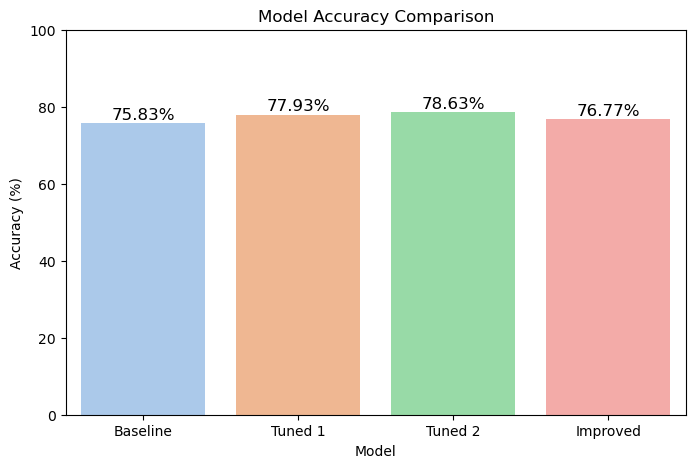

In [43]:
# Compiling results
results = [
    {"Model": "Baseline", "Accuracy": round(baseline_acc * 100, 2)},
    {"Model": "Tuned 1", "Accuracy": round(tuned_accuracies[0][1] * 100, 2)},
    {"Model": "Tuned 2", "Accuracy": round(tuned_accuracies[1][1] * 100, 2)},
    {"Model": "Improved", "Accuracy": round(improved_acc * 100, 2)},
]

results_df = pd.DataFrame(results)
print("\nComparison Table:\n")
print(results_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='pastel')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add accuracy values on top of bars
for index, row in results_df.iterrows():
    plt.text(index, row['Accuracy'] + 1, f"{row['Accuracy']}%", ha='center', fontsize=12)

plt.show()

**Result Analysis**

Model Comparison

The Baseline model achieved a test accuracy of 75.83%, serving as a solid starting point with a simple architecture. After performing hyperparameter tuning, Tuned Model 1 (with a learning rate of 0.001 and dropout rate of 0.5) showed improved performance, reaching 77.93% accuracy. Tuned Model 2, which used a slightly lower learning rate of 0.0005 and a smaller dropout rate of 0.3, performed the best among all, achieving 78.63% accuracy, suggesting that this combination helped the model generalize better. The Improved model, which featured a deeper architecture with batch normalization and more dense units, attained an accuracy of 76.77%. While it performed better than the baseline, it did not outperform the best tuned model, indicating that model depth alone does not guarantee improved performance without optimal tuning of other hyperparameters.



**Analysis and Hyperparameter Optimization Summary**

What Worked and Why:

This project involved building several CNN models to classify histopathologic cancer images, starting with a simple baseline and progressively improving through hyperparameter tuning and architectural changes.

The baseline model, with a single convolutional layer and basic dense layers, achieved a solid 75.8% test accuracy by effectively extracting spatial features.

Hyperparameter tuning focused on learning rate and dropout rate improved results, with the best tuned model reaching 78.6% accuracy using a lower learning rate (0.0005) and moderate dropout (0.3). The smaller learning rate likely helped stabilize training, while reduced dropout preserved important features.

An improved model added more convolutional filters, batch normalization, and dropout layers, achieving 76.8% accuracy. However, this model showed less stable validation performance and longer training times, indicating potential overfitting or insufficient tuning.

**Conclusion and Takeaways**

What helped improve performance:

- Careful hyperparameter tuning (especially learning rate and dropout rate) had a noticeable positive impact on accuracy, more than increasing model complexity alone.

- Using a smaller learning rate (0.0005) allowed more precise optimization, and a moderate dropout (0.3) prevented over-regularization.

- Even the simple baseline CNN achieved decent performance, highlighting the importance of solid fundamentals before complexity.

What didn’t help as much:

- Increasing convolution filters and adding batch normalization/dropout layers without additional tuning did not guarantee better results.

- The improved model showed signs of overfitting or unstable training, indicating that more careful balancing of complexity and regularization is needed.

**Future Improvements to Try:**

- Data Augmentation: Introduce random flips, rotations, zooms, and shifts to increase training data diversity and reduce overfitting.

- More Conv Layers: Add deeper convolutional blocks to extract more complex features, combined with pooling and batch norm.

- Learning Rate Scheduling: Use learning rate decay or adaptive schedulers to optimize training dynamics.

- More Robust Early Stopping: Combine with model checkpoints to save the best weights.

- Transfer Learning: Use pretrained CNN backbones (e.g., ResNet, EfficientNet) fine-tuned on this dataset for better feature extraction.


